In [1]:
import pickle
from time import time
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

## Load testing subset

In [2]:
df_test = pd.read_pickle('./text/newsgroups/test.pkl')
print(df_test.shape)

(7532, 2)


## Load pre-built feature transformer

In [3]:
VOCABULARY_SIZE = ['trim', 35000, 70000, 100000]

## Create features from testing subset

In [4]:
corpus_test = df_test['tokens'].map(lambda x: ' '.join(x))

## Evaluate model accuracy

In [5]:
models = [
    'GaussianNB',
    'AdaBoost',
    'RandomForestClassifier',
    'Bagging',
    'MLPClassifier',
    'LinearSVC'
]

In [6]:
best_model = {}
best_score = 0
model_scores = { 'name': [], 'accuracy': []}
for vocab_size in VOCABULARY_SIZE:
    transformer = None
    with open('./models/tfidf_transformer_{}.pkl'.format(vocab_size), 'rb') as f:
        transformer = pickle.load(f)
        
    X_test = transformer.transform(corpus_test).toarray()
    y_test = df_test['categoryid']
    
    for model_name in models:
        model = None
        with open('./models/{}_{}.pkl'.format(model_name, vocab_size), 'rb') as f:
            model = pickle.load(f)
            start_time = time()
            y_pred = model.predict(X_test)
            duration = time() - start_time
            
            accuracy = accuracy_score(y_test, y_pred)
            
            print('{} : {:.6f} - {:.2f} secs'.format(model_name, accuracy, duration))
            
            model_scores['name'].append('{}-{}'.format(model_name, vocab_size))
            model_scores['accuracy'].append(accuracy)

            if (accuracy > best_score):
                best_score = accuracy
                best_model['model'] = '{}-{}'.format(model_name, vocab_size)
                best_model['confusion_matrix'] = confusion_matrix(y_test, y_pred)
                best_model['recall_category'] = recall_score(y_test, y_pred, average=None)
                best_model['classes'] = model.classes_

GaussianNB : 0.488449 - 5.00 secs
AdaBoost : 0.341609 - 3.35 secs
RandomForestClassifier : 0.644849 - 6.58 secs
Bagging : 0.467339 - 3.70 secs
MLPClassifier : 0.617897 - 0.59 secs
LinearSVC : 0.654010 - 0.18 secs
GaussianNB : 0.531864 - 14.24 secs
AdaBoost : 0.336564 - 9.39 secs
RandomForestClassifier : 0.653213 - 9.34 secs
Bagging : 0.468534 - 9.23 secs
MLPClassifier : 0.610064 - 1.27 secs
LinearSVC : 0.667817 - 0.42 secs
GaussianNB : 0.541423 - 29.79 secs
AdaBoost : 0.337759 - 19.87 secs
RandomForestClassifier : 0.661046 - 12.58 secs
Bagging : 0.470924 - 18.81 secs
MLPClassifier : 0.641529 - 2.48 secs
LinearSVC : 0.673526 - 0.60 secs
GaussianNB : 0.541954 - 42.41 secs
AdaBoost : 0.379580 - 27.73 secs
RandomForestClassifier : 0.678173 - 13.55 secs
Bagging : 0.509958 - 27.10 secs
MLPClassifier : 0.625332 - 3.24 secs
LinearSVC : 0.692246 - 0.85 secs


## Confusion matrix plot: best model

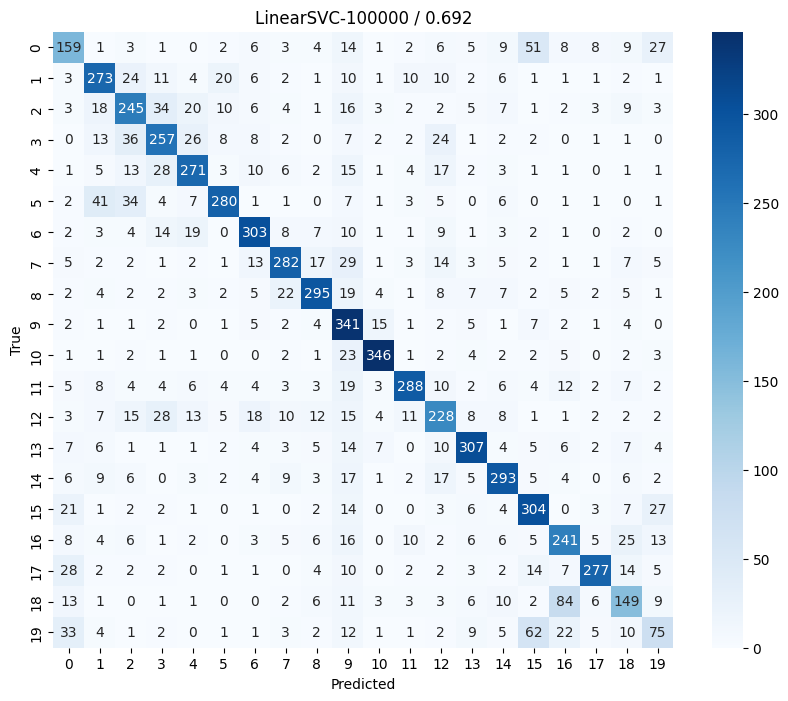

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(best_model['confusion_matrix'], annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title('{} / {:.3f}'.format(best_model['model'], best_score))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Models accurracy compared

In [8]:
df_models = pd.DataFrame(data=model_scores)
df_models

,name,accuracy
0,GaussianNB-trim,0.488449
1,AdaBoost-trim,0.341609
2,RandomForestClassifier-trim,0.644849
3,Bagging-trim,0.467339
4,MLPClassifier-trim,0.617897
5,LinearSVC-trim,0.654010
6,GaussianNB-35000,0.531864
7,AdaBoost-35000,0.336564
8,RandomForestClassifier-35000,0.653213
9,Bagging-35000,0.468534


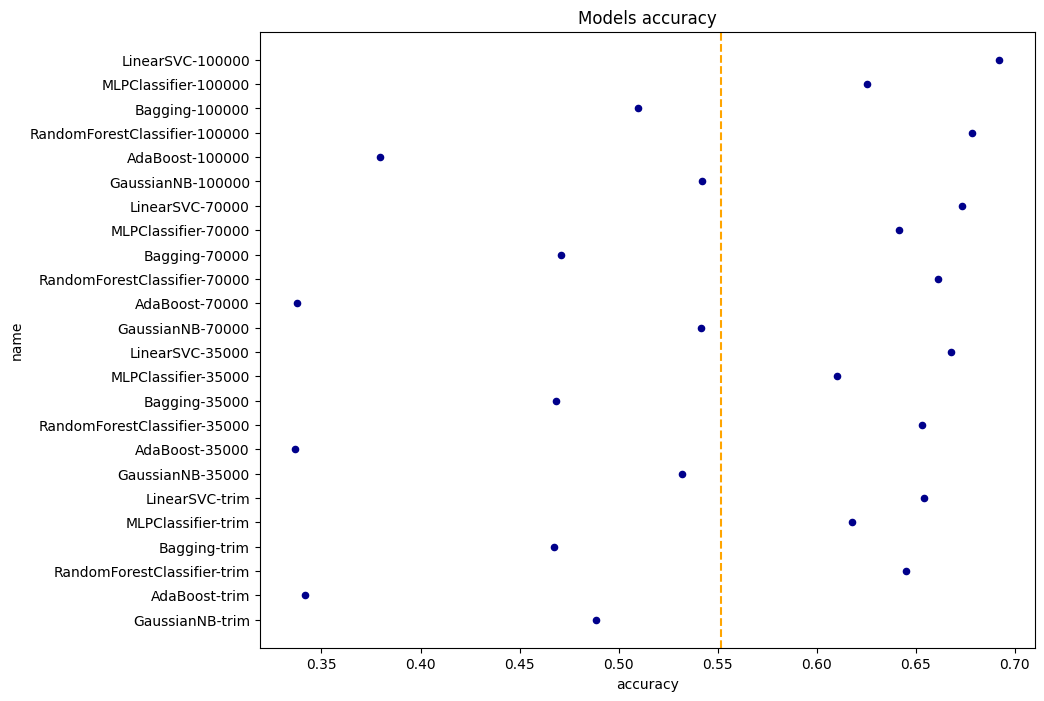

In [14]:
ax = df_models.plot.scatter(y='name', x='accuracy', c='DarkBlue', figsize=(10, 8))
average_accuracy = df_models['accuracy'].mean()
ax.axvline(x=average_accuracy, color='orange', linestyle='--', label='Average Accuracy')
ax.set_title('Models accuracy')
plt.show()

## Recall score per category

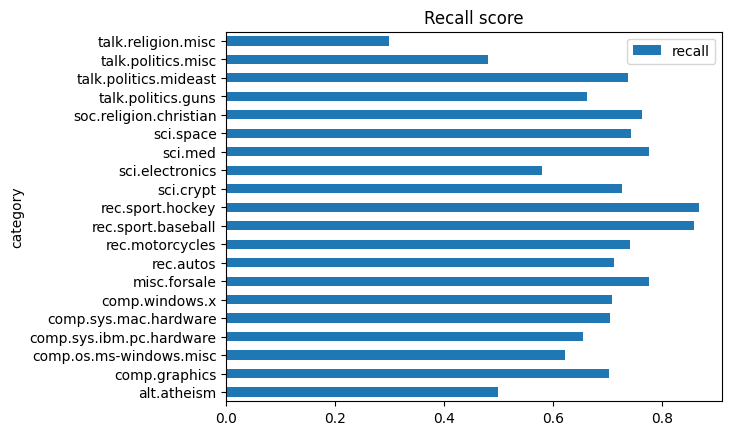

In [10]:
df_cat = pd.read_pickle('./text/newsgroups/categories.pkl')

df_recall_category = pd.DataFrame(data={
    'categoryid': best_model['classes'],
    'recall': best_model['recall_category']
})

df_recall_category= df_recall_category.merge(df_cat, how='inner', left_on='categoryid', right_on='id')
df_recall_category.rename(columns={'name': 'category'}, inplace=True)
ax = df_recall_category.plot.barh(x='category', y='recall')
ax.set_title('Recall score')
plt.show()